# QICK on chip DAC to Voltage Mapping

This program outputs the voltage from QICK, and meausres it with oscilloscope (Keysight DSO-X 6004A)

## Import Libraries

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import pyvisa
from typing import Union, Any
from pprint import pprint

from qick import *
from qick.averager_program import QickSweep
from qick.pyro import make_proxy

rm = pyvisa.ResourceManager()
visa_addr = "USB0::0x0957::0x1780::MY60101437::0::INSTR"
oscilloscope = rm.open_resource(visa_addr)
print(oscilloscope.query("*IDN?"))
oscilloscope.write(":TIMebase:RANGe 0.00005")

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

AGILENT TECHNOLOGIES,DSO-X 6004A,MY60101437,07.31.2020012834

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_3cde8b18d45b4d708deec1c942f4b4c0@192.168.2.99:34289


In [38]:
oscilloscope.write(":CHAN4:RANG 2")
float(oscilloscope.query(":CHAN4:RANG?"))

2.0

## Measurement Program

In [45]:
class DC_Voltage_Meas(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        # Declare DC generation channel
        self.declare_gen(
            ch      = cfg["ch"],        # Channel
            nqz     = 1,        # Nyquist Zone
        )
        self.declare_readout(
            ch      = 0,
            length  = 160,
        )
        self.set_pulse_registers(
            ch      = cfg["ch"],        # Generator channel
            style   = "const",  # Output is constant
            gain    = cfg["gain"],
            mode    = "periodic",
            length  = 32,
            freq    = 0,
            phase   = 0,
            phrst   = 0,
        )
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = 0,        # Readout DDS frequency
            length  = 16,       # Readout DDS multiplication length
            phrst   = 0,        # Readout DDS phase reset
        )
        self.synci(100)
    def body(self):
        cfg = self.cfg
        self.pulse(
            ch      = cfg["ch"],        # Generator channel
            t       = 100       # Pulse will be output @ sync_t + 100
        )
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 50 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all()

def measure_voltage(
        ch: int,
        gain: int,
        oscilloscope, 
        soc,
        soccfg,
    ) -> float:
    cfg = {
        # Experiment Setup
        "ch" : ch,
        "reps" : 1,
        "expts" : 1,
        "gain" : gain,
    }
    prog = DC_Voltage_Meas(
        soccfg,
        cfg
    )
    prog.acquire(soc, progress = False)

    oscilloscope.write(":CHAN4:RANG 2.0")
    oscilloscope.write(":CHAN4:IMP ONEM")
    oscilloscope.write(":SYST:PREC ON")
    oscilloscope.write(":MARK:MODE WAV")
    oscilloscope.write(":MARK:X1Y1Source CH4")
    oscilloscope.write(f":MARK:X1Position 0")

    time.sleep(3)
    voltage = 0
    for i in range(100):
        voltage += float(oscilloscope.query(":MARK:Y1Position?"))
    voltage = voltage / 100
    
    return voltage

## Test

In [42]:

resp = oscilloscope.query(":TIMebase:RANGe?")
print(measure_voltage(100, oscilloscope, soc, soccfg))

-0.02509999999999999


## Measurement

In [50]:
channel = 3

gains = np.linspace(-32766,32766,200).astype(int)

data = {}
for gain in gains:
    data[gain] = measure_voltage(
        ch = channel,
        gain = gain,
        oscilloscope = oscilloscope,
        soc = soc,
        soccfg = soccfg
    )

## Plot and Save it as h5

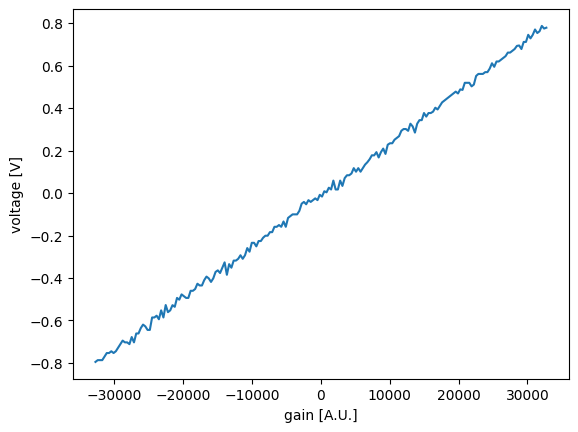

In [53]:
import h5py
from datetime import datetime

voltages = list(data.values())

plt.figure()
plt.plot(gains, voltages)
plt.xlabel("gain [A.U.]")
plt.ylabel("voltage [V]")
plt.show()

naive_dt = datetime.now()
_date = naive_dt.strftime("%Y-%m-%d_%H_%M_%S")
with h5py.File(f"./GainVoltageMap/ch{channel}_gain_voltage_map_{_date}.h5", "w") as f:
    # Store other data types as datasets
    f.create_dataset("gain",data = gains)
    f.create_dataset("voltage",data = voltages)

## Reset Output voltage as 0

In [52]:
cfg = {
    # Experiment Setup
    "ch" : channel,
    "reps" : 1,
    "expts" : 1,
    "gain" : 0,
}
prog = DC_Voltage_Meas(
    soccfg,
    cfg
)
prog.acquire(soc, progress = False)

([array([0.])], [array([0.])])